# Pricing of a Barrier Option With a Risky Counterparty
## Implementing Non-Constant Rate and Varying Volatility

The following code is used to study the impact of the counterparty risk on European barrier option pricing with relaxed Black-Scholes assumptions about constant volatility and constant risk-free rates. This is be done by implementing local volatility and LIBOR forward rates calibrated to market forward rates deduced from given market zero-coupon bond prices.

First, LIBOR Forward Market Model computations are run, followed by preliminary path simulations where share and firm value paths are simulated independently from the forward rate path and compared to jointly simulated paths which are computed with changing forward rates simulated under the LIBOR model.

Finally, the barrier up-and-out call option values without and with counterparty default risk are comupted, using discount factors from the LIBOR model.

Assumptions of the Black-Scholes-Merton model are made, using the following parameters: 
* The maturity of the option is in a year’s time 
* The option is struck at-the-money 
* The up-and-out barrier for the option is \$150
* The current share price is \$100
* The current firm value for the counterparty is \$200
* The counterparty’s debt, due in one year, is \$175 
* The correlation between the counterparty and the stock is constant at 0.2 
* The recovery rate with the counterparty is 25%.
* The local volatility factor γ for both the stock and firm is 0.75
* The standard deviation σ for both the stock and firm values is 0.3

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
import math
import pandas as pd
from tqdm import tqdm


np.random.seed(100)

url="https://raw.githubusercontent.com/darkosisak/DataWQU/master/TB1YR.csv" # calling hystorical T-Bill data
TB_data = pd.read_csv(url, na_values = ['no info', '.'])                    # loading T-Bill rates, making sure no data and data types are handled
TB_mean10 = np.mean(TB_data["TB1YR"][-120:])/100                            # the mean of hystorical 1 Year T-Bill rates since 2009-05-01 to April 2019
TB_mean = np.mean(TB_data["TB1YR"][-12:])/100                               # the mean of hystorical 1 Year T-Bill rates since 2018-05-01 to April 2019
TB_meanAll = np.mean(TB_data["TB1YR"][:])/100                               # the mean of hystorical 1 Year T-Bill rates since 1959-07-01 to April 2019


# Common input
r = TB_mean        # the annual risk-free rate as the mean of hystorical 1 Year T-Bill rates since 2008-06-01 to April 2019
sigma = 0.3        # sqrt of the variance
gamma = 0.75       # γ for local volatility

# Share specific inputs
S0 = 100           # share price

# Firm specific inputs
delta = 0.25       # counterparty recovery rate 
V0 = 200           # firm value
debt = 175         # firm's debt

# Option specific inputs
K = 100            # ATM strike price (e.g. struck at the money = S0)
L = 150            # up-and-out barrier
T = 1              # maturity in years

# Simulation related inputs
N = 12             # periods (12=months)
I = 100000         # simulations

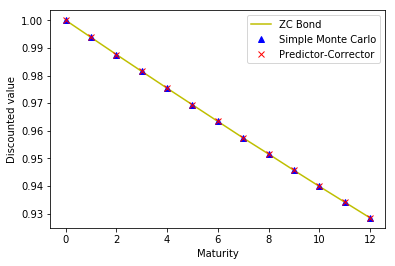

In [0]:
##################################################################################
# Step 1 -- LFMM calculations
##################################################################################

zcb = np.array([1., 0.9938, 0.9876, 0.9815, 0.9754, 0.9694, 0.9634, 0.9574, 0.9516, 0.9457, 0.9399, 0.9342, 0.9285])
sigmaj = np.std(zcb)    # LFMM volatility

np.random.seed(0)

# Number of years and simulations
n_simulations = 100000    # Number of MC simulations at each step
n_steps = 13             # Number of steps (months+0)

# Preallocating matrices
mc_forward = np.ones([n_simulations,n_steps-1])*(zcb[:-1]-zcb[1:])/(2*zcb[1:])
predcorr_forward = np.ones([n_simulations,n_steps-1])*(zcb[:-1]-zcb[1:])/(2*zcb[1:])
predcorr_capfac = np.ones([n_simulations,n_steps])
mc_capfac = np.ones([n_simulations,n_steps])

delta = np.ones([n_simulations,n_steps-1])*2 # matrix storing time increments

# Simulations
for i in range(1,n_steps):
  Z = norm.rvs(size = [n_simulations,1])
  
  # Explicit Monte Carlo simulation
  muhat = np.cumsum(delta[:,i:]*mc_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*mc_forward[:,i:]),axis=1) # equation (13)
  mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z) # equation (12)
  
  # Predictor-Corrector MC simulation
  mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]),axis=1) # equation (16)
  for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z) # equation (14)
  mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp),axis=1) # equation (17)
  predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*Z) # equation (18)

  
# Implying capitalisation factors from the forward rates
mc_capfac[:,1:] = np.cumprod(1+delta*mc_forward, axis=1)
predcorr_capfac[:,1:] = np.cumprod(1+delta*predcorr_forward, axis=1)

# Inverting the capitalisation factors to imply bond prices (discount factors)
mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

# Taking averages
mc_final = np.mean(mc_price,axis=0)
predcorr_final = np.mean(predcorr_price,axis=0)

# Plotting
plt.xlabel("Maturity")
plt.ylabel("Discounted value")
plt.plot(zcb, label="ZC Bond", color="y")
plt.plot(mc_final, "^", label="Simple Monte Carlo", color="b")
plt.plot(predcorr_final, "x", label="Predictor-Corrector", color="r")
plt.legend()
plt.show()

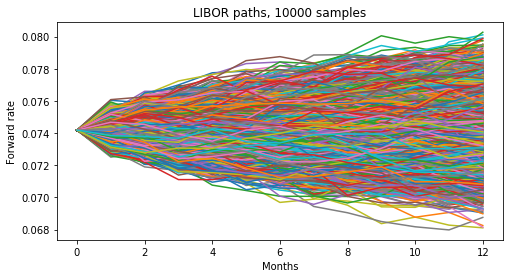

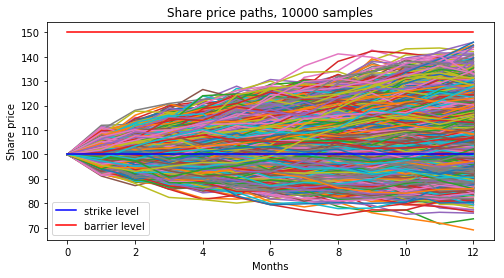

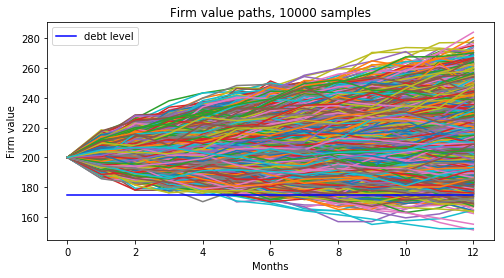

Barrier tripped 0 times in 10000 share path simulations
Share Price Average at Term:  107.81764696376827
Firm Value Average at Term:  215.72273769451218
                                                   
-------- Simulations with constant risk free rate --------
Barrier tripped 0 times in 10000 share path simulations
Share Price Average at Term:  102.55276380995736
Firm Value Average at Term:  205.05048193807238


In [0]:
##################################################################################
# Step 2 -- Path simulations and calculating the default-free value of the option 
##################################################################################

# Local volatility function
def sigma_loc(u):
  return sigma*u**(gamma-1)

# ZCB market rates manipulation
zcb_market = np.array([1., 0.9938, 0.9876, 0.9815, 0.9754, 0.9694, 0.9634, 0.9574, 0.9516, 0.9457, 0.9399, 0.9342, 0.9285])
sigmaj = np.std(zcb_market) # LFMM volatility

mc_forward = np.ones([I,N])*(zcb_market[:-1]-zcb_market[1:])/(2*zcb_market[1:])
predcorr_forward = np.ones([I,N])*(zcb_market[:-1]-zcb_market[1:])/(2*zcb_market[1:])
predcorr_capfac = np.ones([I,N])
mc_capfac = np.ones([I,N])
delta = T/N

#---------------------------------------------------------  
# Preliminary path simulations with visualisation
#---------------------------------------------------------

I = 10000

np.random.seed(0)

Sc = np.zeros([I,N+1])              # creating zeroed array for the share path with constant risk-free rate
Vc = np.zeros([I,N+1])              # creating zeroed array for the firm path with constant risk-free rate
Fmc = np.zeros([I,N+1])             # creating zeroed array for the forward rate path
S = np.zeros([I,N+1])               # creating zeroed array for the share path
V = np.zeros([I,N+1])               # creating zeroed array for the firm path

# setting barrier hit counters to zero
hits = 0                           
hits_f = 0

for y in range(0,I):
    
    Sc[y,0]=S0 
    Vc[y,0]=V0
    Fmc[y,0]=np.log(zcb_market[0]/zcb_market[12])    # initial rate from given ZCB values (should we use 1Y fwd rate (np.log(99.38/92.85))?)
    S[y,0]=S0 
    V[y,0]=V0
    
    beenhit = False
    beenhit_f = False
   
    for x in range(0,N):
        # Separate path simulations 
        muhat = np.cumsum((T/N)*Fmc[y,x]*sigmaj**2/(1+(T/N)*Fmc[y,x]))
        Fmc[y,x+1] = Fmc[y,x]*(np.exp((muhat-(sigmaj**2)/2)*T/N + sigmaj*np.sqrt(T/N)*np.random.normal(0,1)))       
        Sc[y,x+1] = Sc[y,x]*(np.exp((r-(sigma_loc(Sc[y,x])**2)/2)*T/N + sigma_loc(Sc[y,x])*np.sqrt(T/N)*np.random.normal(0,1))) 
        Vc[y,x+1] = Vc[y,x]*(np.exp((r-(sigma_loc(Vc[y,x])**2)/2)*T/N + sigma_loc(Vc[y,x])*np.sqrt(T/N)*np.random.normal(0,1)))
        # Joined path simulations
        S[y,x+1] = S[y,x]*(np.exp((Fmc[y,x]-(sigma_loc(S[y,x])**2)/2)*T/N + sigma_loc(S[y,x])*np.sqrt(T/N)*np.random.normal(0,1))) 
        V[y,x+1] = V[y,x]*(np.exp((Fmc[y,x]-(sigma_loc(V[y,x])**2)/2)*T/N + sigma_loc(V[y,x])*np.sqrt(T/N)*np.random.normal(0,1)))
        
        if Sc[y,x] > L:
            if beenhit==False:
              hit = 1
              hits += hit
              beenhit=True
              
        if S[y,x] > L:
            if beenhit==False:
              hit_f = 1
              hits_f += hit_f
              beenhit_f=True
              
    plt.figure(1, figsize=(8,4))
    plt.plot(Fmc[y])
    
    plt.figure(2, figsize=(8,4))
    plt.plot(S[y])
    
    plt.figure(3, figsize=(8,4))
    plt.plot(V[y])
    
    
# Plotting the paths
plt.figure(1)  
plt.title("LIBOR paths, %d samples"%(I))
plt.xlabel("Months")
plt.ylabel("Forward rate")

plt.figure(2)  
plt.title("Share price paths, %d samples"%(I))
plt.xlabel("Months")
plt.ylabel("Share price")
plt.plot([K]*13, label = "strike level", color = "b")
plt.plot([L]*13, label = "barrier level", color = "r")
plt.legend()

plt.figure(3)  
plt.title("Firm value paths, %d samples"%(I))
plt.xlabel("Months")
plt.ylabel("Firm value")
plt.plot([debt]*13, label = "debt level", color = "b")
plt.legend()

plt.show() 

# Path comparison
TermShareAvg = np.average(S[:,-1]) 
TermFirmAvg = np.average(V[:,-1])

TermShareAvgR = np.average(Sc[:,-1]) 
TermFirmAvgR = np.average(Vc[:,-1])

print("Barrier tripped", hits, "times in",I,"share path simulations")
print("Share Price Average at Term: ", TermShareAvg)
print("Firm Value Average at Term: ",  TermFirmAvg)
print("                                                   ")
print("-------- Simulations with constant risk free rate --------")
print("Barrier tripped", hits, "times in",I,"share path simulations")
print("Share Price Average at Term: ", TermShareAvgR)
print("Firm Value Average at Term: ",  TermFirmAvgR)

In [0]:
#---------------------------------------------------------  
# Jointly simulating paths and computing payoffs
#---------------------------------------------------------

dt = T/12           # resolution for path simulation, i.e. T/steps
n_t = 12            # steps
n_sim = 100000      # number of simulations

# calculating payoffs from share paths
def uno_call_payoff(share_path,K,L):
  if max(share_path)>=L:
    return 0
  if share_path[-1] - K > 0:
    return share_path[-1] - K
  return 0

# simulating paths
def simulate_path(S,r,sigma,dt,Z):
   return S*math.exp((r-(sigma**2)/2)*dt + sigma*math.sqrt(dt)*Z)

# creating 1 row matrixes to store the random walks  
F = np.zeros((1, n_t+1), dtype=float)   
S = np.zeros((1, n_t+1), dtype=float)  
V = np.zeros((1, n_t+1), dtype=float)   

def price_uno_call(sigma,r,K,L,S0,T,dt,n_t,n_sim):
  #  creating 1 column matrix to store all the final computed payoffs:
  all_final_payoffs = np.zeros((n_sim, 1), dtype=float)

  # loop 2: sampling (*n_sim)
  for i in range(0,n_sim):    
    F[0,0] = np.log(zcb_market[0]/zcb_market[12])   # setting first value of the random walk to given zcb market     
    S[0,0] = S0                                     # setting first value of the random walk to S0   
    V[0,0] = V0                                     # setting first value of the random walk to V0
      
    # loop 1: random walk steps (*n_t) 
    for j in range(1, n_t+1):
      # forward rate path simulation
      mu_initial = np.cumsum(dt*F[0, j - 1]*sigmaj**2/(1+(dt)*F[0, j - 1])) # equation (16)
      for_temp = F[0, j - 1]*np.exp((mu_initial-sigmaj**2/2)*dt+sigmaj*np.sqrt(dt)*np.random.normal(0,1)) # equation (14)
      mu_term = np.cumsum(dt*for_temp*sigmaj**2/(1+dt*for_temp)) # equation (17)
      F[0,j] = simulate_path(F[0, j - 1], mu_initial+mu_term, sigmaj, dt, np.random.normal(0,1)) # equation (18)
      
      # joint path simulations
      S[0,j] = simulate_path(S[0, j - 1], F[0,j-1], sigma_loc(S[0, j-1]), dt, np.random.normal(0,1))
      V[0,j] = simulate_path(V[0, j - 1], F[0,j-1], sigma_loc(V[0, j-1]), dt, np.random.normal(0,1))
      
    # computing payoff for the generated random walk and storing the values in "all_final_payoffs"
    all_final_payoffs[i, 0] = uno_call_payoff(S[0, :], K, L)
    
  #---------------------------------------------------------  
  # Final calculation of the default-free option value
  #---------------------------------------------------------  
  option_price = np.mean(all_final_payoffs) * np.mean(predcorr_price) # discount factor replaced by discount factor from LFMM
  variance_payoff = np.std(all_final_payoffs)
  upper_bound_95 = option_price + 1.96 * variance_payoff / math.sqrt(n_sim)
  lower_bound_95 = option_price - 1.96 * variance_payoff / math.sqrt(n_sim)
   
  print("Option price, no default risk : {}".format(option_price))
  print("95% confident price interval : [{} ; {}]".format(lower_bound_95, upper_bound_95))
  print (np.mean(all_final_payoffs))
              
price_uno_call(sigma,r,K,L,S0,T,dt,n_t,n_sim)

Option price, no default risk : 8.55961248169265
95% confident price interval : [8.507193566344261 ; 8.612031397041038]
8.881899391727993


In [0]:
##################################################################################
# Step 3 -- Monte Carlo estimates incorporating counter-party risk 
##################################################################################

#---------------------------------------------------------  
# Monte Carlo estimation of the CVA value
#---------------------------------------------------------

random.seed(0)

def terminal_value(S_0, r, sigma, Z, T):
    return S_0 * np.exp((r - sigma**2/2) * T + sigma*np.sqrt(T)*Z)
  
dt = T/12           # resolution for path simulation, i.e. T/steps
n_t = 12            # steps 
n_sim = 10000       # number of simulations

cva_estimates = [None]

all_final_payoffs_cor = np.zeros((n_sim, 1), dtype=float)

correlation = 0.2
  
corr_matrix = np.array([[1,correlation],[correlation,1]])
norm_matrix = norm.rvs(size = np.array([2,n_sim+n_t]))
corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix),norm_matrix)

# computing the correlated share price paths
for i in range(0,n_sim):
  S = np.zeros((1, n_t+1), dtype=float)     # creating 1 row matrix to store the random walk
  S[0,0] = S0                               # setting first value of the random walk to S0
  
  V = np.zeros((1, n_t+1), dtype=float)     # creating 1 row matrix to store the random walk
  V[0,0] = V0                               # setting first value of the random walk to V0
      
  # random-walk loop 
  for j in range(1, n_t+1):
    Z = np.array([corr_norm_matrix[0,][j+i]])
    S[0,j] = simulate_path(S[0,j-1], F[0,j-1], sigma_loc(S[0,j-1]), dt, Z)
    V[0,j] = simulate_path(V[0,j-1], F[0,j-1], sigma_loc(V[0,j-1]), dt, Z)

    # computing payoff for the generated random walk and storing the values in "all_final_payoffs"
    all_final_payoffs_cor[i,0] = uno_call_payoff(S[0, :], K, L)
    
    option_cor = np.mean(all_final_payoffs_cor) * np.mean(predcorr_price) # discount factor replaced by discount factor from LFMM    
    term_firm_val = terminal_value(V0,F[0,j-1],sigma_loc(V[0, j-1]),corr_norm_matrix[1,],T) 
amount_lost = np.exp(-r*T)*(1-delta)*(term_firm_val < debt)*option_cor
cva_estimates = np.mean(amount_lost)

print ("CVA estimate: ",round(np.mean(cva_estimates),3))

CVA estimate:  0.027


In [0]:
#--------------------------------------------------------------  
# Monte Carlo estimation of the option value incorporating risk
#--------------------------------------------------------------
n_sim = 100000
def price_uno_callCVA(sigma,r,K,L,S0,T,dt,n_t,n_sim):
  #  creating 1 column matrix to store all the final computed payoffs:
  allCVA_final_payoffs = np.zeros((n_sim, 1), dtype=float)
 
  for i in range(0,n_sim):
    S = np.zeros((1, n_t), dtype=float)     # creating 1 row matrix to store the random walk
    S[0, 0] = S0                            # setting first value of the random walk to S0   
    
    for j in range(1, n_t):
      S[0, j] = simulate_path(S[0, j - 1], F[0,j-1], sigma_loc(S[0, j-1]), dt, np.random.normal(0,1))
 
    # computing payoff minus CVA for the generated random walk and storing the values in "all_final_payoffs":
    allCVA_final_payoffs[i, 0] = uno_call_payoff(S[0, :], K, L)-np.mean(cva_estimates)
    
  optionCVA_price = np.mean(allCVA_final_payoffs) * np.mean(predcorr_price)   # discount factor replaced by discount factor from LFMM
  variance_payoff = np.std(allCVA_final_payoffs)
  upper_bound_95 = optionCVA_price + 1.96 * variance_payoff / math.sqrt(n_sim)
  lower_bound_95 = optionCVA_price - 1.96 * variance_payoff / math.sqrt(n_sim)
  print("Option price, counterparty risk included : {}".format(optionCVA_price))
  print("95% confident price interval : [{} ; {}]".format(lower_bound_95, upper_bound_95))
            
price_uno_callCVA(sigma,r,K,L,S0,T,dt,n_t,n_sim)

Option price, counterparty risk included : 8.023746358638098
95% confident price interval : [7.974130663700143 ; 8.073362053576053]
